# Предложение 1

Ввести дифференцированную оплату в зависимости от зоны посадки/высадки

In [2]:
import clickhouse_connect
import json
from dotenv import load_dotenv
import os
from IPython.display import display
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm

In [3]:
# Read config from file
with open('dags/conf/config.json', 'r') as f:
    CONFIG = json.load(f)

# Load environment variables
load_dotenv('./dags/conf/.env', override=True)

# TODO - for Clickhouse in Docker set host name
CONFIG['clickhouse']['host'] = 'localhost'
db = CONFIG['clickhouse']['dbs']['golden_db']

# Get Clickhouse connection
ch_client = clickhouse_connect.get_client(
    host=CONFIG['clickhouse']['host'],
    port=CONFIG['clickhouse']['port'],
    username=os.getenv('CLICKHOUSE_USER'),
    password=os.getenv('CLICKHOUSE_PASS')
)


In [24]:
def safe_qcut(x):
    """
    Additional data checks before performing qcut
    """
    if x.nunique() < 3:
        return pd.Series(['Medium'] * len(x), index=x.index)
    
    return pd.qcut(x, q=3, labels=['Low','Medium','High'], duplicates='drop')

In [6]:
# Explore how much Manhattan prevails in numbers
# Get aggregated data
sql = f"""
    WITH man AS (
        SELECT ft.fare_amount,
            (dtz1.borough = 'Manhattan' OR dtz2.borough = 'Manhattan') AS is_manhattan
        FROM {db}.fact_trip ft
            JOIN {db}.dim_taxi_zone dtz1
                ON ft.PULocationID = dtz1.taxi_zone_id 
            JOIN {db}.dim_taxi_zone dtz2
                ON ft.DOLocationID = dtz2.taxi_zone_id
    )
    SELECT COUNT(*) AS total_trips,
        SUM(is_manhattan) AS manhattan_trips,
        SUM(fare_amount) AS total_revenue,
        SUM(fare_amount * is_manhattan) AS manhattan_revenue
    FROM man
    """

try:
    df = ch_client.query_df(sql)
    print(df.head(10))

except Exception as e:
    print(f"Error querying data: {e}")
    raise


   total_trips  manhattan_trips  total_revenue  manhattan_revenue
0     17713074         16028917   1.559196e+08       1.414245e+08


In [20]:
results = {
    'Total Trips': df['total_trips'].iloc[0],
    'Manhattan Trips': df['manhattan_trips'].iloc[0],
    'Manhattan Trip %': (df['manhattan_trips'].iloc[0] / df['total_trips'].iloc[0]) * 100,
    'Total Revenue ($)': df['total_revenue'].iloc[0],
    'Manhattan Revenue ($)': df['manhattan_revenue'].iloc[0],
    'Manhattan Revenue %': df['manhattan_revenue'].iloc[0] / df['total_revenue'].iloc[0] * 100
}
print(results)

print(f'\n\nManhattan dominance:')
print(f"  Trips: {round(results['Manhattan Trip %'], 1)}%")
print(f"  Revenue: {round(results['Manhattan Revenue %'], 1)}%")


{'Total Trips': 17713074, 'Manhattan Trips': 16028917, 'Manhattan Trip %': 90.49201171970489, 'Total Revenue ($)': 155919579.2200699, 'Manhattan Revenue ($)': 141424520.86008692, 'Manhattan Revenue %': 90.7035034134333}


Manhattan dominance:
  Trips: 90.5%
  Revenue: 90.7%


In [21]:
# Manhattan prevalence analysis
pd_results = pd.DataFrame([results])
pd_results['Manhattan Trip %'] = pd_results['Manhattan Trip %'].map("{:.2f}%".format)
pd_results['Manhattan Revenue %'] = pd_results['Manhattan Revenue %'].map("{:.2f}%".format)

styled = (pd_results
    .style
    .set_table_styles([
        {"selector": "table", "props": [("border-collapse", "collapse"), ("width", "100%")]},
        {"selector": "th, td", "props": [("border", "1px solid #999"), ("padding", "6px")]},
        {"selector": "th", "props": [("background", "steelblue"), ("text-align", "center")]},
        {"selector": "td", "props": [("background", "white"), ("color", "black")]},
    ])
    .hide(axis="index")
)

display(styled)


Total Trips,Manhattan Trips,Manhattan Trip %,Total Revenue ($),Manhattan Revenue ($),Manhattan Revenue %
17713074,16028917,90.49%,155919579.220070,141424520.860087,90.70%


Text(0.5, 1.0, 'Trip Distribution: Manhattan vs Other Boroughs')

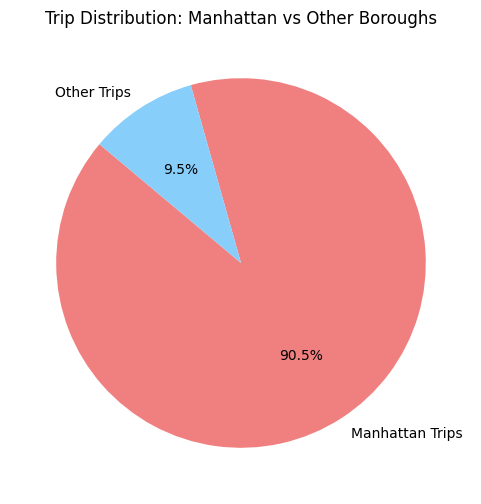

In [22]:
# Plot results on pie chart
labels = ['Manhattan Trips', 'Other Trips']
sizes = [results['Manhattan Trips'], results['Total Trips'] - results['Manhattan Trips']]
colors = ['lightcoral', 'lightskyblue']

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Trip Distribution: Manhattan vs Other Boroughs')

In [32]:
# Get demand statistics for each zone by date and hour
sql = f"""
    SELECT 
        ft.PULocationID AS taxi_zone_id,
        ddt.`date`,
        ddt.is_weekend,
        ddt.`hour`,
        COUNT(*) AS pickup_trips_count,
        AVG(ft.fare_amount) AS pickup_avg_fare,
        SUM(ft.fare_amount) AS pickup_total_fare
    FROM {db}.fact_trip ft
    JOIN {db}.dim_datetime ddt
        ON ft.pickup_datetime_id = ddt.datetime_id
    GROUP BY ft.PULocationID, ddt.`date`, ddt.is_weekend, ddt.`hour`
"""

try:
    # Get pickup zones statistics
    pickup_stats = ch_client.query_df(sql)

    print(pickup_stats.head(10))

except Exception as e:
    print(f"Error querying data: {e}")


   taxi_zone_id       date  is_weekend  hour  pickup_trips_count  \
0            49 2017-01-15        True    14                  36   
1            83 2017-01-01        True    10                  12   
2           151 2017-01-29        True     2                  32   
3            13 2017-02-08       False     5                  17   
4           157 2017-01-09       False    17                   1   
5            40 2017-02-18        True     8                  11   
6           131 2017-01-26       False    13                   1   
7           225 2017-02-13       False     9                   6   
8            37 2017-01-16       False     1                   8   
9           132 2017-02-08       False    23                  14   

   pickup_avg_fare  pickup_total_fare  
0         8.875000              319.5  
1         8.000000               96.0  
2         8.437500              270.0  
3         9.588235              163.0  
4        10.000000               10.0  
5        10

In [33]:
# Segment into demand tiers for each date and hour separately
pickup_stats['demand_tier'] = pickup_stats['pickup_trips_count'].transform(safe_qcut)
print(pickup_stats.head(10))

   taxi_zone_id       date  is_weekend  hour  pickup_trips_count  \
0            49 2017-01-15        True    14                  36   
1            83 2017-01-01        True    10                  12   
2           151 2017-01-29        True     2                  32   
3            13 2017-02-08       False     5                  17   
4           157 2017-01-09       False    17                   1   
5            40 2017-02-18        True     8                  11   
6           131 2017-01-26       False    13                   1   
7           225 2017-02-13       False     9                   6   
8            37 2017-01-16       False     1                   8   
9           132 2017-02-08       False    23                  14   

   pickup_avg_fare  pickup_total_fare demand_tier  
0         8.875000              319.5      Medium  
1         8.000000               96.0      Medium  
2         8.437500              270.0      Medium  
3         9.588235              163.0      

In [42]:
print(f"\nDemand distribution:")
print(pickup_stats['demand_tier'].value_counts())



Demand distribution:
demand_tier
Low       72005
High      67631
Medium    64957
Name: count, dtype: int64


In [43]:
# Examples of high-demand zone-hours
print("\nTop 10 zone-hour combinations by demand:")
top_zones = pickup_stats.nlargest(10, 'pickup_trips_count')[
    ['taxi_zone_id', 'date', 'is_weekend', 'hour', 'pickup_trips_count', 'pickup_total_fare', 'demand_tier']
]
print(top_zones)



Top 10 zone-hour combinations by demand:
        taxi_zone_id       date  is_weekend  hour  pickup_trips_count  \
7213              79 2017-01-29        True     1                1864   
180163            79 2017-01-22        True     1                1809   
4294              79 2017-01-22        True     2                1775   
189389            79 2017-01-29        True     2                1761   
75229             79 2017-02-26        True     1                1707   
185902            79 2017-01-28        True     1                1681   
173565            79 2017-02-19        True     1                1669   
22294             79 2017-02-12        True     1                1643   
40590             79 2017-02-19        True     2                1640   
57591             79 2017-02-05        True     1                1631   

        pickup_total_fare demand_tier  
7213             17700.00        High  
180163           16963.00        High  
4294             16534.00        H

In [36]:
# Get dropoff zone statistics by hour
sql = f"""
    SELECT 
        ft.DOLocationID AS taxi_zone_id,
        ddt.`date`,
        ddt.is_weekend,
        ddt.`hour`,
        COUNT(*) AS dropoff_trips_count
    FROM {db}.fact_trip ft
    JOIN {db}.dim_datetime ddt
        ON ft.pickup_datetime_id = ddt.datetime_id
    GROUP BY ft.DOLocationID, ddt.`date`, ddt.is_weekend, ddt.`hour`
"""

try:
    dropoff_stats = ch_client.query_df(sql)
    print(dropoff_stats.head(10))

except Exception as e:
    print(f"Error getting dropoff statistics: {e}")


   taxi_zone_id       date  is_weekend  hour  dropoff_trips_count
0            82 2017-02-19        True    11                   27
1            70 2017-02-22       False     4                    3
2           143 2017-02-25        True     5                   25
3            52 2017-01-22        True     2                   15
4           159 2017-02-06       False     7                    6
5           106 2017-01-16       False    13                    9
6           247 2017-01-15        True    16                   16
7            62 2017-01-10       False    17                    2
8            15 2017-01-03       False    19                    3
9           265 2017-02-23       False    11                    1


In [37]:
dropoff_stats['dropoff_tier'] = dropoff_stats['dropoff_trips_count'].transform(safe_qcut)

print(dropoff_stats.head(10))


   taxi_zone_id       date  is_weekend  hour  dropoff_trips_count dropoff_tier
0            82 2017-02-19        True    11                   27       Medium
1            70 2017-02-22       False     4                    3          Low
2           143 2017-02-25        True     5                   25       Medium
3            52 2017-01-22        True     2                   15       Medium
4           159 2017-02-06       False     7                    6       Medium
5           106 2017-01-16       False    13                    9       Medium
6           247 2017-01-15        True    16                   16       Medium
7            62 2017-01-10       False    17                    2          Low
8            15 2017-01-03       False    19                    3          Low
9           265 2017-02-23       False    11                    1          Low


In [38]:
# Zone segmentation by demand
styled_pu = (pickup_stats.head(10).sort_values(['taxi_zone_id'])
    .style
    .set_table_styles([
        {"selector": "table", "props": [("border-collapse", "collapse"), ("width", "100%")]},
        {"selector": "th, td", "props": [("border", "1px solid #999"), ("padding", "6px")]},
        {"selector": "th", "props": [("background", "steelblue"), ("text-align", "center")]},
        {"selector": "td", "props": [("background", "white"), ("color", "black")]},
    ])
    .hide(axis="index")
)

display(styled_pu)

styled_do = (dropoff_stats.head(10).sort_values(['taxi_zone_id'])
    .style
    .set_table_styles([
        {"selector": "table", "props": [("border-collapse", "collapse"), ("width", "100%")]},
        {"selector": "th, td", "props": [("border", "1px solid #999"), ("padding", "6px")]},
        {"selector": "th", "props": [("background", "steelblue"), ("text-align", "center")]},
        {"selector": "td", "props": [("background", "white"), ("color", "black")]},
    ])
    .hide(axis="index")
)

display(styled_do)

taxi_zone_id,date,is_weekend,hour,pickup_trips_count,pickup_avg_fare,pickup_total_fare,demand_tier
13,2017-02-08 00:00:00,False,5,17,9.588235,163.000000,Medium
37,2017-01-16 00:00:00,False,1,8,11.687500,93.500000,Medium
40,2017-02-18 00:00:00,True,8,11,10.136364,111.500000,Medium
49,2017-01-15 00:00:00,True,14,36,8.875000,319.500000,Medium
83,2017-01-01 00:00:00,True,10,12,8.000000,96.000000,Medium
131,2017-01-26 00:00:00,False,13,1,6.500000,6.500000,Low
132,2017-02-08 00:00:00,False,23,14,13.357143,187.000000,Medium
151,2017-01-29 00:00:00,True,2,32,8.437500,270.000000,Medium
157,2017-01-09 00:00:00,False,17,1,10.000000,10.000000,Low
225,2017-02-13 00:00:00,False,9,6,9.916667,59.500000,Medium


taxi_zone_id,date,is_weekend,hour,dropoff_trips_count,dropoff_tier
15,2017-01-03 00:00:00,False,19,3,Low
52,2017-01-22 00:00:00,True,2,15,Medium
62,2017-01-10 00:00:00,False,17,2,Low
70,2017-02-22 00:00:00,False,4,3,Low
82,2017-02-19 00:00:00,True,11,27,Medium
106,2017-01-16 00:00:00,False,13,9,Medium
143,2017-02-25 00:00:00,True,5,25,Medium
159,2017-02-06 00:00:00,False,7,6,Medium
247,2017-01-15 00:00:00,True,16,16,Medium
265,2017-02-23 00:00:00,False,11,1,Low


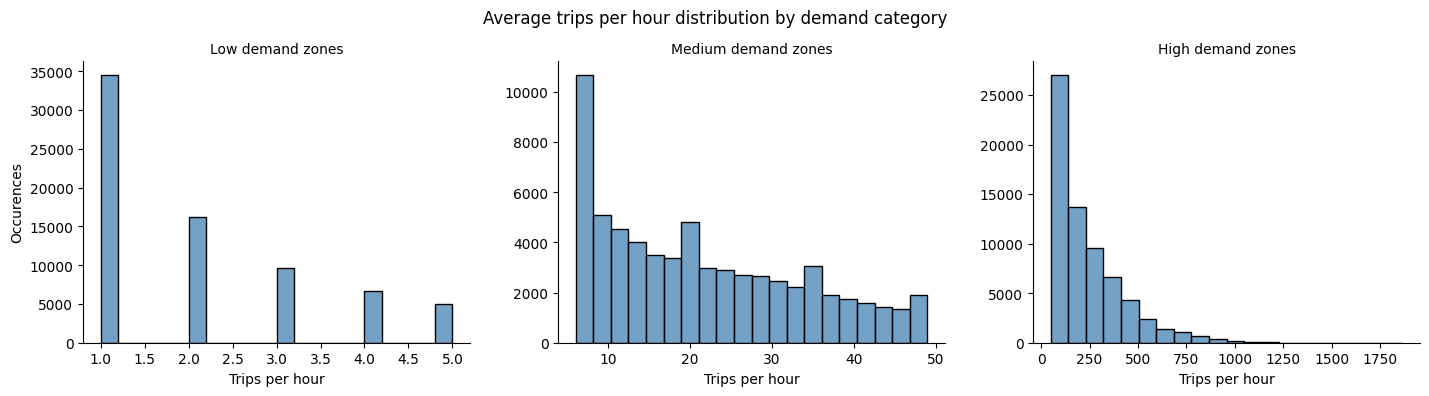

In [40]:
# Plot trips count distribution for each demand category
g = sns.FacetGrid(pickup_stats, col='demand_tier', col_order=['Low', 'Medium', 'High'], sharey=False, sharex=False, height=4, aspect=1.2)
g.map_dataframe(sns.histplot, x='pickup_trips_count', bins=20, color='steelblue')
g.set_axis_labels("Trips per hour", "Occurences")
g.set_titles(col_template="{col_name} demand zones")
g.figure.subplots_adjust(top=0.85)
g.figure.suptitle("Average trips per hour distribution by demand category")

plt.show()


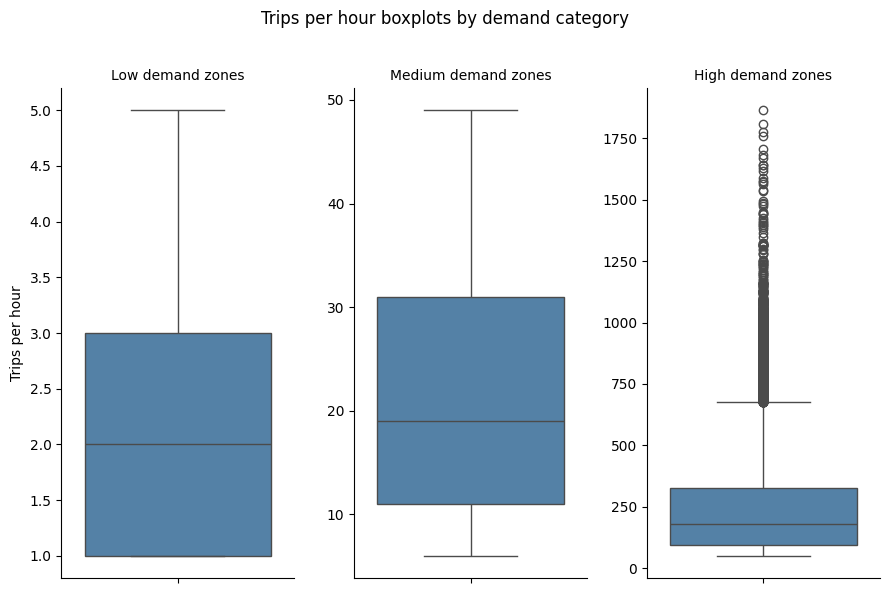

In [45]:
# Plot trips count boxplot for each demand category
g = sns.FacetGrid(pickup_stats, col='demand_tier', col_order=['Low', 'Medium', 'High'], sharey=False, sharex=False, height=6, aspect=0.5)
g.map_dataframe(sns.boxplot, y='pickup_trips_count', color='steelblue')
g.set_axis_labels("", "Trips per hour")
g.set_titles(col_template="{col_name} demand zones")
g.figure.subplots_adjust(top=0.85)
g.figure.suptitle("Trips per hour boxplots by demand category")

plt.show()

In [46]:
pickup_stats.describe()

,taxi_zone_id,date,hour,pickup_trips_count,pickup_avg_fare,pickup_total_fare
count,204593.000000,204593,204593.000000,204593.000000,204593.000000,204593.000000
mean,140.033119,2017-01-30 02:21:07.574159360,11.870445,86.578969,9.034510,762.113531
min,1.000000,2017-01-01 00:00:00,0.000000,1.000000,0.000000,0.000000
25%,75.000000,2017-01-15 00:00:00,6.000000,3.000000,7.905882,23.500000
50%,142.000000,2017-01-30 00:00:00,12.000000,18.000000,8.837687,162.000000
75%,210.000000,2017-02-14 00:00:00,18.000000,92.000000,9.996094,819.500000
max,265.000000,2017-03-01 00:00:00,23.000000,1864.000000,22.000000,17700.000000
std,75.310085,NaN,6.848843,153.316627,2.381900,1347.718492


In [48]:
# Add columns with price and trips count logs
zone_stats_logs = pickup_stats.copy()

# Prepare dataset for taking logs
zone_stats_logs = zone_stats_logs[(zone_stats_logs['pickup_avg_fare'] > 0) & (zone_stats_logs['pickup_trips_count'] > 0)]

# Take logs for log-log regression
zone_stats_logs['log_demand'] = np.log(zone_stats_logs['pickup_trips_count'])
zone_stats_logs['log_price'] = np.log(zone_stats_logs['pickup_avg_fare'])

# Sort dataset by zone and hour
zone_stats_logs = zone_stats_logs.sort_values(['taxi_zone_id', 'hour'])


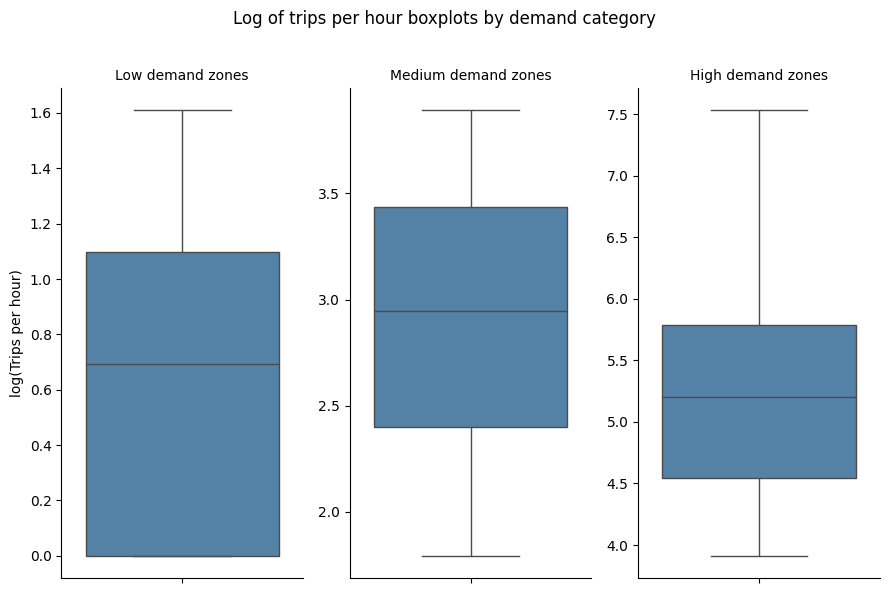

In [49]:
# Plot boxplots for trip count logs
g = sns.FacetGrid(zone_stats_logs, col='demand_tier', col_order=['Low', 'Medium', 'High'], sharey=False, sharex=False, height=6, aspect=0.5)
g.map_dataframe(sns.boxplot, y='log_demand', color='steelblue')
g.set_axis_labels("", "log(Trips per hour)")
g.set_titles(col_template="{col_name} demand zones")
g.figure.subplots_adjust(top=0.85)
g.figure.suptitle("Log of trips per hour boxplots by demand category")

plt.show()

In [52]:
demand_data = zone_stats_logs.copy()
# Add dummies and cast fileds to float to use in OLS model
demand_data = pd.get_dummies(demand_data, columns=['hour'], dtype=float, drop_first=True)
demand_data['is_weekend'] = demand_data['is_weekend'].astype(float)
print(demand_data.dtypes)

taxi_zone_id                  uint16
date                  datetime64[ns]
is_weekend                   float64
pickup_trips_count            uint64
pickup_avg_fare              float64
pickup_total_fare            float64
demand_tier                 category
log_demand                   float64
log_price                    float64
hour_1                       float64
hour_2                       float64
hour_3                       float64
hour_4                       float64
hour_5                       float64
hour_6                       float64
hour_7                       float64
hour_8                       float64
hour_9                       float64
hour_10                      float64
hour_11                      float64
hour_12                      float64
hour_13                      float64
hour_14                      float64
hour_15                      float64
hour_16                      float64
hour_17                      float64
hour_18                      float64
h

In [57]:
# Calculate demand elasticity
elasticity_by_tier = {}

for tier in ['High', 'Medium', 'Low']:
    tier_data = demand_data[demand_data['demand_tier'] == tier].copy()
    
    if len(tier_data) < 30:
        print(f"  {tier}: Not enough data (n={len(tier_data)})")
        continue
    
    X = tier_data[['log_price', 'is_weekend'] + [c for c in demand_data.columns if c.startswith('hour_')]].copy()
    y = tier_data['log_demand']

    model_tier = sm.OLS(y, X).fit()
    
    print('\n\n', '+' * 10, tier.upper(), '+' * 40)
    print(model_tier.summary())
    print('+' * 60)


    elasticity_by_tier[f'{tier}'] = model_tier.params['log_price']
    elasticity_by_tier[f'{tier}_R2'] = model_tier.rsquared




 ++++++++++ HIGH ++++++++++++++++++++++++++++++++++++++++
                                 OLS Regression Results                                
Dep. Variable:             log_demand   R-squared (uncentered):                   0.977
Model:                            OLS   Adj. R-squared (uncentered):              0.977
Method:                 Least Squares   F-statistic:                          1.160e+05
Date:                Fri, 12 Dec 2025   Prob (F-statistic):                        0.00
Time:                        18:34:30   Log-Likelihood:                         -80177.
No. Observations:               67631   AIC:                                  1.604e+05
Df Residuals:                   67606   BIC:                                  1.606e+05
Df Model:                          25                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      

In [58]:
print(elasticity_by_tier)

{'High': 2.0831651628340566, 'High_R2': 0.9772188666439544, 'Medium': 1.2091758862335338, 'Medium_R2': 0.9526929801276728, 'Low': 0.16597512047198587, 'Low_R2': 0.4692596343792961}


In [60]:
# Price elasticity table view
elasticity_tbl = pd.DataFrame(elasticity_by_tier, index=[0])

styled = (
    elasticity_tbl
    .style
    .set_table_styles([
        {"selector": "table", "props": [("border-collapse", "collapse"), ("width", "100%")]},
        {"selector": "th, td", "props": [("border", "1px solid #999"), ("padding", "6px")]},
        {"selector": "th", "props": [("background", "steelblue"), ("text-align", "center")]},
        {"selector": "td", "props": [("background", "white"), ("color", "black")]},
    ])
    .hide(axis="index")
)

display(styled)

High,High_R2,Medium,Medium_R2,Low,Low_R2
2.083165,0.977219,1.209176,0.952693,0.165975,0.469260


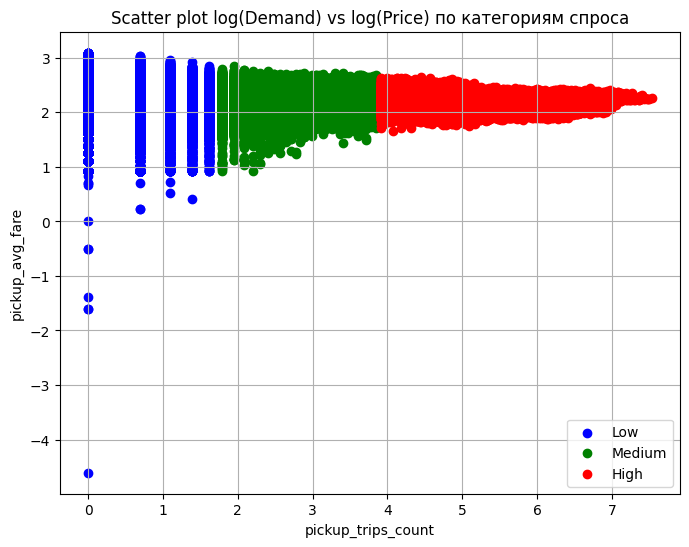

In [61]:
# Цвета для категорий
colors = {'Low': 'blue', 'Medium': 'green', 'High': 'red'}

# Построение scatter plot
plt.figure(figsize=(8,6))
for tier in zone_stats_logs['demand_tier'].unique():
    subset = zone_stats_logs[zone_stats_logs['demand_tier'] == tier]
    plt.scatter(subset['log_demand'], subset['log_price'], 
                label=tier, color=colors[tier])

plt.xlabel('pickup_trips_count')
plt.ylabel('pickup_avg_fare')
plt.title('Scatter plot log(Demand) vs log(Price) по категориям спроса')
plt.legend()
plt.grid(True)
plt.show()

D:\Temp\ipykernel_8240\2785118246.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


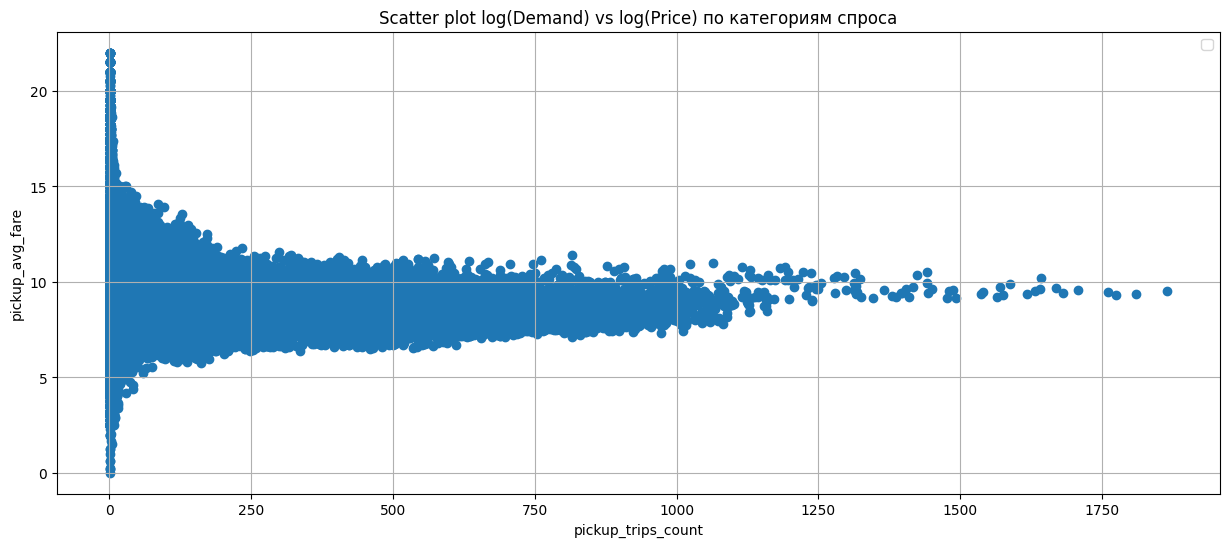

In [63]:
plt.figure(figsize=(15,6))
plt.scatter(zone_stats_logs['pickup_trips_count'], zone_stats_logs['pickup_avg_fare'])
plt.xlabel('pickup_trips_count')
plt.ylabel('pickup_avg_fare')
plt.title('Scatter plot log(Demand) vs log(Price) по категориям спроса')
plt.legend()
plt.grid(True)
plt.show()

In [84]:
# Merge pickup and dropoff zone-hour tiers without dates
full_df = pickup_stats[['taxi_zone_id', 'is_weekend', 'hour', 'pickup_trips_count',
                    'pickup_avg_fare', 'pickup_total_fare', 'demand_tier']] \
    .merge(
    dropoff_stats[['taxi_zone_id', 'is_weekend', 'hour', 'dropoff_tier']], 
    on=['taxi_zone_id', 'is_weekend', 'hour'], 
    suffixes=('_pu', '_do')
)

# Add column with elasticity for each row
full_df['elasticity'] = full_df['demand_tier'].map(elasticity_by_tier).astype(float)

# Create trip type column based on pickup-dropoff tier combination
full_df['trip_type'] = full_df['demand_tier'].astype(str) + '-' + full_df['dropoff_tier'].astype(str)

print(full_df.head(10))

   taxi_zone_id  is_weekend  hour  pickup_trips_count  pickup_avg_fare  \
0            49        True    14                  36            8.875   
1            49        True    14                  36            8.875   
2            49        True    14                  36            8.875   
3            49        True    14                  36            8.875   
4            49        True    14                  36            8.875   
5            49        True    14                  36            8.875   
6            49        True    14                  36            8.875   
7            49        True    14                  36            8.875   
8            49        True    14                  36            8.875   
9            49        True    14                  36            8.875   

   pickup_total_fare demand_tier dropoff_tier  elasticity      trip_type  
0              319.5      Medium         High    1.209176    Medium-High  
1              319.5      Medium   

In [85]:
# Get aggregated values for each trip type by hour
agg_df = full_df.groupby(['trip_type', 'elasticity'], as_index=False).agg({
    'pickup_trips_count': 'mean',
    'pickup_avg_fare': 'mean',
    'pickup_total_fare': 'mean'
})

print(agg_df.head(10))

       trip_type  elasticity  pickup_trips_count  pickup_avg_fare  \
0      High-High    2.083165          253.028366         8.791115   
1       High-Low    2.083165           62.295783        11.527425   
2    High-Medium    2.083165           73.253081         9.388099   
3       Low-High    0.165975            3.607474         9.056185   
4        Low-Low    0.165975            1.875112         9.116785   
5     Low-Medium    0.165975            2.642663         8.988473   
6    Medium-High    1.209176           29.731162         8.934724   
7     Medium-Low    1.209176           11.627427         9.505375   
8  Medium-Medium    1.209176           18.975318         9.128963   

   pickup_total_fare  
0        2213.654227  
1         709.312169  
2         685.870283  
3          32.566223  
4          17.027081  
5          23.654576  
6         265.768291  
7         113.566703  
8         174.809508  


In [86]:
styled = (agg_df.sort_values(['pickup_total_fare'], ascending=False)
    .style
    .set_table_styles([
        {"selector": "table", "props": [("border-collapse", "collapse"), ("width", "100%")]},
        {"selector": "th, td", "props": [("border", "1px solid #999"), ("padding", "6px")]},
        {"selector": "th", "props": [("background", "steelblue"), ("text-align", "center")]},
        {"selector": "td", "props": [("background", "white"), ("color", "black")]},
    ])
    .hide(axis="index")
)

display(styled)

trip_type,elasticity,pickup_trips_count,pickup_avg_fare,pickup_total_fare
High-High,2.083165,253.028366,8.791115,2213.654227
High-Low,2.083165,62.295783,11.527425,709.312169
High-Medium,2.083165,73.253081,9.388099,685.870283
Medium-High,1.209176,29.731162,8.934724,265.768291
Medium-Medium,1.209176,18.975318,9.128963,174.809508
Medium-Low,1.209176,11.627427,9.505375,113.566703
Low-High,0.165975,3.607474,9.056185,32.566223
Low-Medium,0.165975,2.642663,8.988473,23.654576
Low-Low,0.165975,1.875112,9.116785,17.027081




 ++++++++++ BASELINE ++++++++++++++++++++++++++++++++++++++++
     trip_type  elasticity  pickup_trips_count  pickup_avg_fare  \
0    High-High    2.083165          253.028366         8.791115   
1     High-Low    2.083165           62.295783        11.527425   
2  High-Medium    2.083165           73.253081         9.388099   
3     Low-High    0.165975            3.607474         9.056185   
4      Low-Low    0.165975            1.875112         9.116785   

   pickup_total_fare scenario_name  price_multiplier  price_new   trips_new  \
0        2213.654227      baseline                 1   8.791115  253.028366   
1         709.312169      baseline                 1  11.527425   62.295783   
2         685.870283      baseline                 1   9.388099   73.253081   
3          32.566223      baseline                 1   9.056185    3.607474   
4          17.027081      baseline                 1   9.116785    1.875112   

   revenue_new  revenue_change  revenue_change_pct  trips_

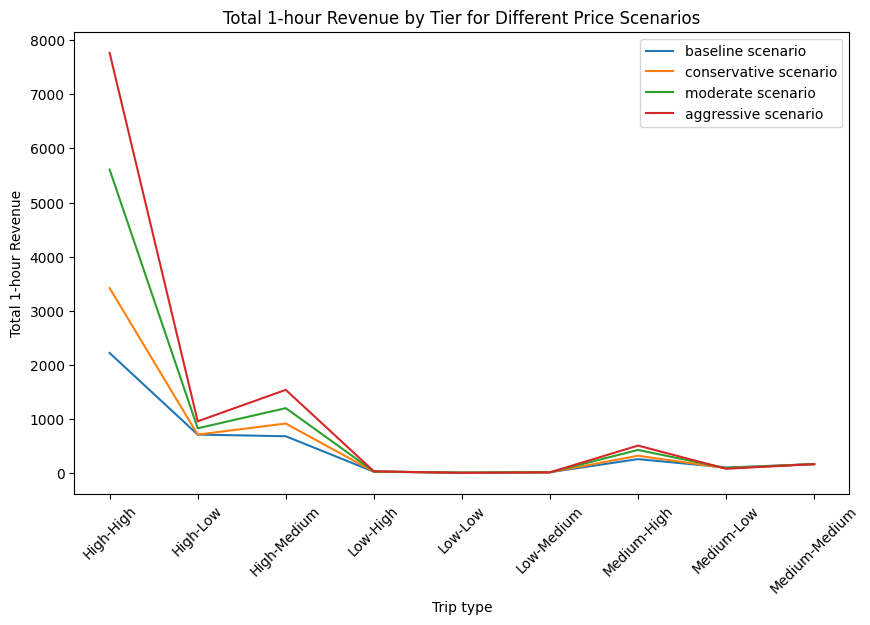

In [146]:
# Define pricing scenarios based on tier pairs
scenarios = {
    'baseline': {
        'High-High': 1, 'High-Medium': 1, 'High-Low': 1,
        'Medium-High': 1, 'Medium-Medium': 1, 'Medium-Low': 1,
        'Low-High': 1, 'Low-Medium': 1, 'Low-Low': 1
    },
    'conservative': {
        'High-High': 1.15, 'High-Medium': 1.10, 'High-Low': 1.00,
        'Medium-High': 1.10, 'Medium-Medium': 1.00, 'Medium-Low': 0.95,
        'Low-High': 1.05, 'Low-Medium': 0.95, 'Low-Low': 0.90
    },
    'moderate': {
        'High-High': 1.35, 'High-Medium': 1.20, 'High-Low': 1.05,
        'Medium-High': 1.25, 'Medium-Medium': 1.00, 'Medium-Low': 0.95,
        'Low-High': 1.15, 'Low-Medium': 0.95, 'Low-Low': 0.80
    },
    'aggressive': {
        'High-High': 1.50, 'High-Medium': 1.30, 'High-Low': 1.10,
        'Medium-High': 1.35, 'Medium-Medium': 1.00, 'Medium-Low': 0.90,
        'Low-High': 1.20, 'Low-Medium': 0.90, 'Low-Low': 0.70
    }
}

results_df = pd.DataFrame()

plt.figure(figsize=(10,6))

for scenario_name, price_multipliers in scenarios.items():
    df_scenario = agg_df.copy()
    
    # Add scenario name column
    df_scenario['scenario_name'] = scenario_name

    # Add price multipliers based on trip type
    df_scenario['price_multiplier'] = df_scenario['trip_type'].map(price_multipliers)

    # Calculate new values
    df_scenario['price_new'] = df_scenario['pickup_avg_fare'] * df_scenario['price_multiplier']
    df_scenario['trips_new'] = df_scenario['pickup_trips_count'] * (df_scenario['price_multiplier']) ** df_scenario['elasticity']
    df_scenario['revenue_new'] = df_scenario['trips_new'] * df_scenario['price_new'] 
    df_scenario['revenue_change'] = df_scenario['revenue_new'] - df_scenario['pickup_total_fare']
    df_scenario['revenue_change_pct'] = ((df_scenario['revenue_new'] - df_scenario['pickup_total_fare']) / df_scenario['pickup_total_fare']) * 100
    df_scenario['trips_change_pct'] = ((df_scenario['trips_new'] - df_scenario['pickup_trips_count']) / df_scenario['pickup_trips_count']) * 100
    
    print('\n\n', '+' * 10, scenario_name.upper(), '+' * 40)
    print(df_scenario.head(5))
    print('+'*60)
   
    results_df = pd.concat([results_df, df_scenario])

    plt.plot(df_scenario['trip_type'], df_scenario['revenue_new'], label=f'{scenario_name} scenario')

plt.xlabel('Trip type')
plt.xticks(rotation=45)
plt.ylabel('Total 1-hour Revenue')
plt.title('Total 1-hour Revenue by Tier for Different Price Scenarios')
plt.legend()
plt.show()


In [153]:
print(results_df.head(10))

       trip_type  elasticity  pickup_trips_count  pickup_avg_fare  \
0      High-High    2.083165          253.028366         8.791115   
1       High-Low    2.083165           62.295783        11.527425   
2    High-Medium    2.083165           73.253081         9.388099   
3       Low-High    0.165975            3.607474         9.056185   
4        Low-Low    0.165975            1.875112         9.116785   
5     Low-Medium    0.165975            2.642663         8.988473   
6    Medium-High    1.209176           29.731162         8.934724   
7     Medium-Low    1.209176           11.627427         9.505375   
8  Medium-Medium    1.209176           18.975318         9.128963   
0      High-High    2.083165          253.028366         8.791115   

   pickup_total_fare scenario_name  price_multiplier  price_new   trips_new  \
0        2213.654227      baseline              1.00   8.791115  253.028366   
1         709.312169      baseline              1.00  11.527425   62.295783   
2  

In [148]:
# Show scenarios parameters
scenarios_df = pd.DataFrame.from_dict(scenarios, orient='index')
styled = (
    scenarios_df.T
    .style
    .format("{:.2f}")
    .set_table_styles([
        {"selector": "table", "props": [("border-collapse", "collapse"), ("width", "100%")]},
        {"selector": "th, td", "props": [("border", "1px solid #999"), ("padding", "6px")]},
        {"selector": "th", "props": [("background", "steelblue"), ("text-align", "center")]},
        {"selector": "td", "props": [("background", "white"), ("color", "black")]},
    ])
    # .hide(axis="index")
)

display(styled)


,baseline,conservative,moderate,aggressive
High-High,1.00,1.15,1.35,1.50
High-Medium,1.00,1.10,1.20,1.30
High-Low,1.00,1.00,1.05,1.10
Medium-High,1.00,1.10,1.25,1.35
Medium-Medium,1.00,1.00,1.00,1.00
Medium-Low,1.00,0.95,0.95,0.90
Low-High,1.00,1.05,1.15,1.20
Low-Medium,1.00,0.95,0.95,0.90
Low-Low,1.00,0.90,0.80,0.70


In [157]:
# Show scenarios results
results_disp = results_df[['scenario_name', 'trip_type', 'pickup_trips_count', 'pickup_avg_fare',
            'pickup_total_fare', 'price_new', 'trips_new',
            'revenue_new', 'revenue_change', 'revenue_change_pct',
            'trips_change_pct']]
results_disp.loc[results_disp.duplicated(subset=['scenario_name']), 'scenario_name'] = ''

styled = (results_disp.set_index('scenario_name')
    .style
    # .format("{:.2f}")
    .set_table_styles([
        {"selector": "table", "props": [("border-collapse", "collapse"), ("width", "100%")]},
        {"selector": "th, td", "props": [("border", "1px solid #999"), ("padding", "6px")]},
        {"selector": "th", "props": [("background", "steelblue"), ("text-align", "center")]},
        {"selector": "td", "props": [("background", "white"), ("color", "black")]},
    ])
    # .hide(axis="index")
)
    

display(styled)

,trip_type,pickup_trips_count,pickup_avg_fare,pickup_total_fare,price_new,trips_new,revenue_new,revenue_change,revenue_change_pct,trips_change_pct
scenario_name,,,,,,,,,,
baseline,High-High,253.028366,8.791115,2213.654227,8.791115,253.028366,2224.401402,10.747175,0.485495,0.000000
,High-Low,62.295783,11.527425,709.312169,11.527425,62.295783,718.109946,8.797777,1.240325,0.000000
,High-Medium,73.253081,9.388099,685.870283,9.388099,73.253081,687.707166,1.836882,0.267818,0.000000
,Low-High,3.607474,9.056185,32.566223,9.056185,3.607474,32.669954,0.103731,0.318524,0.000000
,Low-Low,1.875112,9.116785,17.027081,9.116785,1.875112,17.094992,0.067910,0.398838,0.000000
,Low-Medium,2.642663,8.988473,23.654576,8.988473,2.642663,23.753504,0.098928,0.418219,0.000000
,Medium-High,29.731162,8.934724,265.768291,8.934724,29.731162,265.639720,-0.128571,-0.048377,0.000000
,Medium-Low,11.627427,9.505375,113.566703,9.505375,11.627427,110.523058,-3.043645,-2.680050,0.000000
,Medium-Medium,18.975318,9.128963,174.809508,9.128963,18.975318,173.224973,-1.584535,-0.906435,0.000000


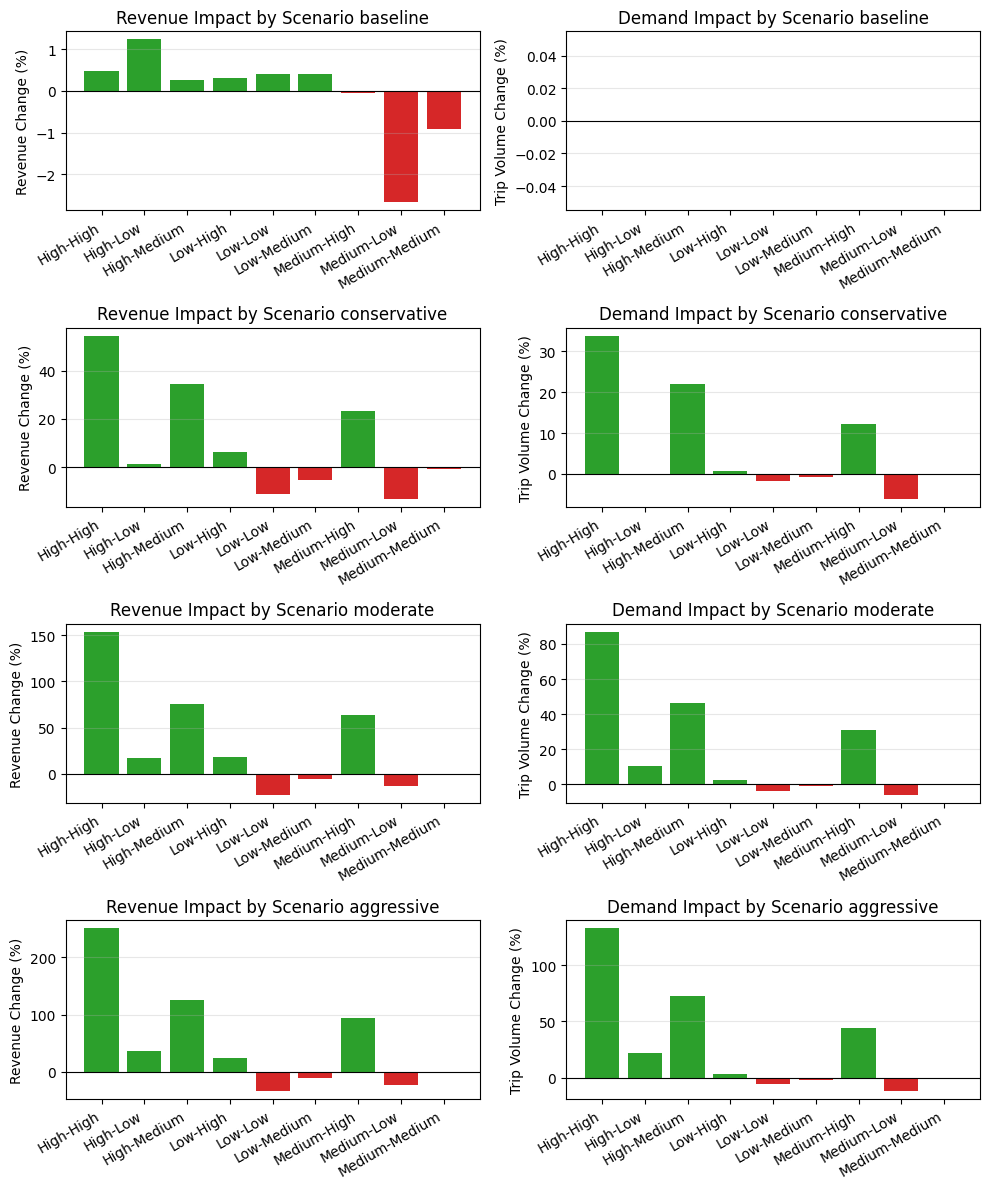

In [215]:
fig, axes = plt.subplots(4, 2, figsize=(10, 12), sharex=False, sharey=False)
axes = axes.ravel()
    
scenarios = results_df['scenario_name'].drop_duplicates()

for idx, scenario in enumerate(scenarios):
    ax = axes[2*idx]
    cur_result = results_df[results_df['scenario_name'] == scenario]

    # Plot total revenue impact
    revenue_change = cur_result['revenue_change_pct']
    trip_types = cur_result['trip_type']
    colors_scenario = ['#7f7f7f' if x == 'baseline' else '#2ca02c' if x > 0 else '#d62728' 
                        for x in revenue_change]
    
    ax.bar(cur_result['trip_type'], revenue_change, color=colors_scenario)
    ax.set_xticks(range(len(trip_types)))
    ax.set_xticklabels(trip_types, rotation=30, ha='right')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    ax.set_ylabel('Revenue Change (%)')
    ax.set_title(f'Revenue Impact by Scenario {scenario}')
    ax.grid(axis='y', alpha=0.3)

    ax = axes[2*idx+1]

    # Plot trips count impact
    trips_change = cur_result['trips_change_pct']
    colors_trips = ['#7f7f7f' if x == 'baseline' else '#2ca02c' if x > 0 else '#d62728' 
                    for x in trips_change]
    ax.bar(cur_result['trip_type'], trips_change, color=colors_trips)
    ax.set_xticks(range(len(trip_types)))
    ax.set_xticklabels(trip_types, rotation=30, ha='right')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    ax.set_ylabel('Trip Volume Change (%)')
    ax.set_title(f'Demand Impact by Scenario {scenario}')
    ax.grid(axis='y', alpha=0.3)


plt.tight_layout()
plt.show()
